In [8]:
import numpy as np
import eqcorrscan

from eqcorrscan import Tribe
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.event import (
    Catalog, Event, Pick, WaveformStreamID, Origin)
from obspy.geodetics import gps2dist_azimuth

## Download a catalog of events

For now, we're going to go with located events from July 17-19 2014 under Mount St. Helens (17 located events). If you want to adjust the dates or query, that should be obvious how to do so in the `client.get_events()` function.

In [9]:
client = Client("USGS")
catalog = client.get_events(
    starttime=UTCDateTime(2014, 7, 17),
    endtime=UTCDateTime(2014, 7, 19),
    latitude=46.2, longitude=-122.19,
    maxradius=0.25)

print(catalog.count())

17


Events at volcanoes are tough to locate, especially if they're small. If you don't have a template, you'll never find them with template detection. I used REDPy to see what else was going on around this time, and I'm going to take one event out of a family there and see what we can find with it.

Event we'll use triggered at 2014-07-25T16:57:57.08. We don't have a location, so let's just assume it's near the summit at a depth of about 2 km b.s.l.

In [10]:
event_solo = Event()
event_solo.origins = [Origin()]
event_solo.origins[0].time = UTCDateTime('2014-07-25T16:57:57.08') - 2  # assume about 2 seconds from origin to trigger time
event_solo.origins[0].latitude = 46.2
event_solo.origins[0].longitude = -122.19
event_solo.origins[0].depth = 2000

# Append to the catalog
catalog += event_solo

print(catalog)

18 Event(s) in Catalog:
2014-07-18T22:48:15.530000Z | +46.201, -122.181 | -0.47 mh | manual
2014-07-18T21:34:55.770000Z | +46.199, -122.183 | 0.35 ml | manual
...
2014-07-17T05:01:50.110000Z | +46.411, -122.260 | 0.09 md | manual
2014-07-25T16:57:55.080000Z | +46.200, -122.190
To see all events call 'print(CatalogObject.__str__(print_all=True))'


## Make templates!

Unfortunately, pick information for these earthquakes is not available to my knowledge through web queries (PNSN doesn't publish them with a nice API). Besides, they wouldn't have picked events on the temporary stations we want to use anyway.

So what we're going to do is make a very rough estimate the P-wave arrival time at the locations of our stations of interest and use that as the start of our template window. If you were doing a big relative relocation study you'd work with actual pick times and shorter windows around P- and S-, but for sake of demonstration this is a good starting point if you're just looking to find more events.

In [12]:
# Get your inventory of stations (weak motion only, thus *HZ)
# We're going to go with a 0.25º radius around Mount St. Helens summit;
# you could go further out but this is stretching what's probably visible
# based on the magnitude of the events we're looking at...

client = Client("IRIS")
inventory = client.get_stations(starttime=UTCDateTime(2014, 7, 17),
    endtime=UTCDateTime(2014, 7, 19),
    latitude=46.2, longitude=-122.19,
    maxradius=0.25, channel='*HZ', level='channel')
print(len(inventory))

4


In [13]:
# Loop over events and create picks for each channel based on distance of the station from source
# and a very simple assumption of 5 km/s wave speed. Could be more fancy by doing wave tracing
# through an actual velocity structure, but I'm just doing a rough first pass.

p_vel = 5000  # m/s 
for event in catalog:
    picks = []
    for channel in inventory.get_contents()['channels']:
        # XD (iMUSH deployment) broadbands have LHZ, BHZ, and HHZ channels; we only need HHZ
        if channel[:2] != 'XD' or (channel[:2] == 'XD' and channel[-3:] == 'HHZ'):
            distance = np.sqrt(gps2dist_azimuth(
                event.origins[0].latitude,
                event.origins[0].longitude,
                inventory.get_channel_metadata(channel)['latitude'],
                inventory.get_channel_metadata(channel)['longitude']
            )[0]**2 + (event.origins[0].depth + inventory.get_channel_metadata(channel)['elevation'])**2)
            picks += [
                Pick(
                    time=event.origins[0].time +  distance/p_vel,
                    waveform_id=WaveformStreamID(
                        network_code=channel.split('.')[0],
                        station_code=channel.split('.')[1],
                        channel_code=channel.split('.')[3],
                        location_code=channel.split('.')[2],
                    ),
                    phase_hint='P'
                )
            ]
    event.picks = picks
    print(len(event.picks))

52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52


In [14]:
# Make the templates with eqcorrscan

# We're constructing templates with a 10-second window to capture P and S with a bit of filtering.
# These can all be adjusted but should match the filtering and processing length you plan to use to
# scan through the continuous data. 

# There are a lot of stations and quite a few possible channels (40+)... we can reduce the search space if needed

tribe = Tribe().construct(
    method="from_client",
    client_id="IRIS",
    catalog=catalog,
    lowcut=1.0,
    highcut=10.0,
    samp_rate=50.0,
    filt_order=4,
    length=10.0,
    prepick=1,
    process_len=86400,
    all_horiz=False,
    parallel=True,
    min_snr=3.0,
)

# Ignore the warnings!

No data available for request.
HTTP Status code: 204
Detailed response of server:


Found no data for this station: {'network': 'CC', 'station': 'JRO', 'location': '*', 'channel': 'BHZ', 'starttime': UTCDateTime(2014, 7, 17, 5, 0, 20, 110000), 'endtime': UTCDateTime(2014, 7, 18, 5, 0, 20, 110000)}
No data available for request.
HTTP Status code: 204
Detailed response of server:


Found no data for this station: {'network': 'XD', 'station': 'MG07', 'location': '*', 'channel': 'HHZ', 'starttime': UTCDateTime(2014, 7, 17, 5, 0, 20, 110000), 'endtime': UTCDateTime(2014, 7, 18, 5, 0, 20, 110000)}
Signal-to-noise ratio 2.33120130909806 below threshold for SEP.EHZ, not using
No pick for CC.SEP..EHZ
Signal-to-noise ratio 2.4196063653921476 below threshold for STD.BHZ, not using
No pick for CC.STD..BHZ
Signal-to-noise ratio 2.712679654905657 below threshold for VALT.BHZ, not using
No pick for CC.VALT..BHZ
Signal-to-noise ratio 0.025523335415546234 below threshold for B201.LHZ, not using
No pick

## Detection!

Now we run the templates through continuous data and see what wasn't located by the network. There's a *lot* going on under the hood here...

In [ ]:
party = tribe.client_detect(
    client=client,
    starttime=UTCDateTime(2014,7,15),
    endtime=UTCDateTime(2014,8,10),
    threshold=10,
    threshold_type="MAD",
    trig_int=1.0,
    concurrent_processing=True,
)

Streams in queue will be edited in-place, you should not re-use them


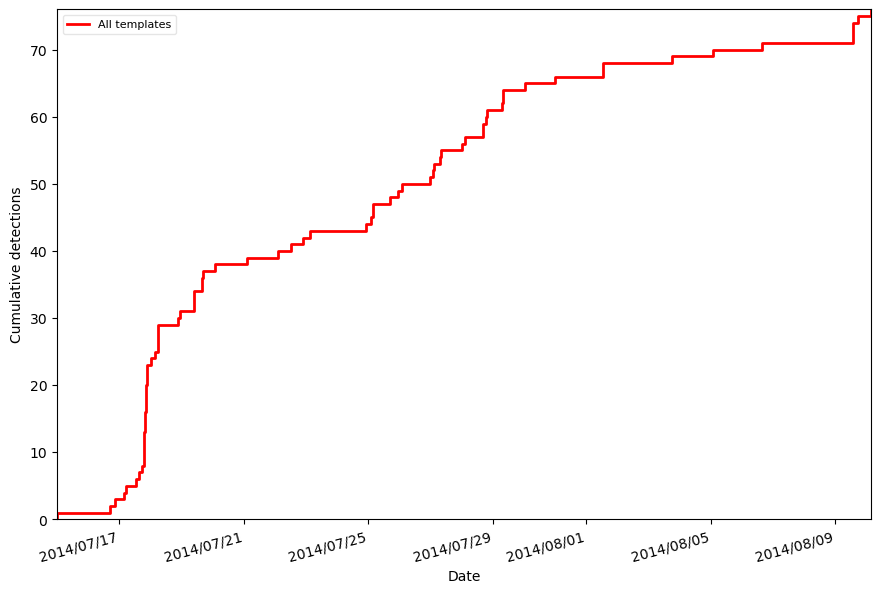

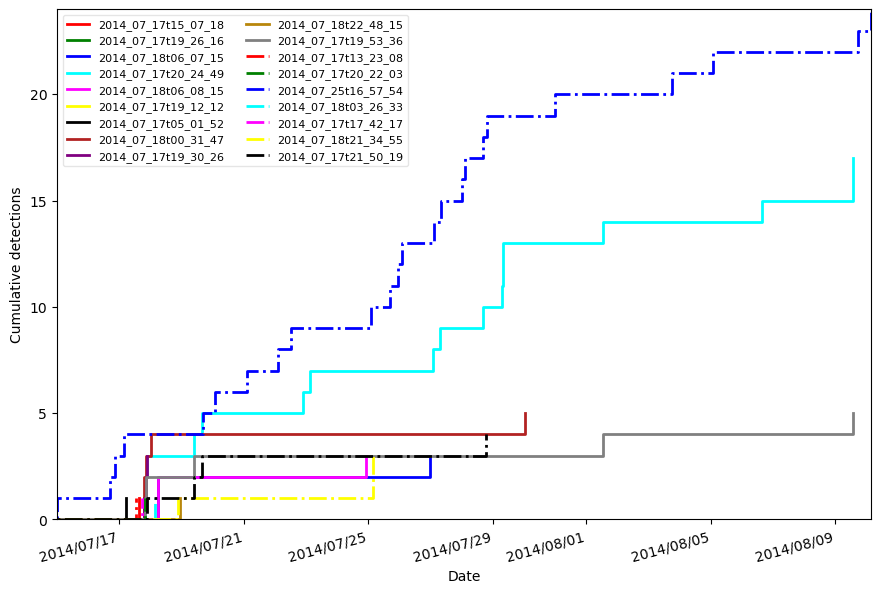

Number of templates: 18
Number of additional detections: 58


In [9]:
party.plot(plot_grouped=True)
party.plot(plot_grouped=False)

print(f'Number of templates: {len(tribe)}')
print(f'Number of additional detections: {len(party)-len(tribe)}')

So, we've added some additional detections, though not a lot. Note that two of the templates (2014-07-17T20:24:49 and the unlocated one we added at 2014-07-25T16:57:55) are matching the most events by themselves. There are also templates that are matching each other, but we don't count those as additional detections since we're requiring that detections have to be at least 1 second apart from each other (`trig_int`).

## Other thoughts...

From here, I think you could take a few detections and try to plot up data from the nodal arrays that were out and make record sections or something. I tried to only search in dates that were around the time of the nodal deployment so you have a good chance of getting a few detections/events at those times. Actually looking at the data is important, and is not something I've done much recently in the scope of this package.

Good luck! Hopefully this is enough to give you a good start.